In [1]:
import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import numpy as np
import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yijieding/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv(
    "../data/cases_f_cleaned.csv",
    encoding="utf-8",
    encoding_errors="ignore",
    engine="c",
    on_bad_lines="warn",
)

In [3]:
df = df.dropna(subset=['description','service_offering','u_organization'],how='any')

In [4]:
ITS_df = df[df["u_organization"] == "IT Services"]

In [5]:
category_count = ITS_df["service_offering"].value_counts()[:10]

categories = category_count.index

category_num = len(categories)

category_num, category_count, categories

(10,
 Active Directory - ITS                   39126
 Spam / Duplicate Case                    34380
 MultiFactor Authentication               27884
 Non ITS Support                          23102
 Office 365                               13719
 Enterprise Software Licensing Support    11781
 Online Directory                         11699
 Canvas LMS                               10848
 Single Sign-on                           10398
 Hardware Endpoint Support                 9187
 Name: service_offering, dtype: int64,
 Index(['Active Directory - ITS', 'Spam / Duplicate Case',
        'MultiFactor Authentication', 'Non ITS Support', 'Office 365',
        'Enterprise Software Licensing Support', 'Online Directory',
        'Canvas LMS', 'Single Sign-on', 'Hardware Endpoint Support'],
       dtype='object'))

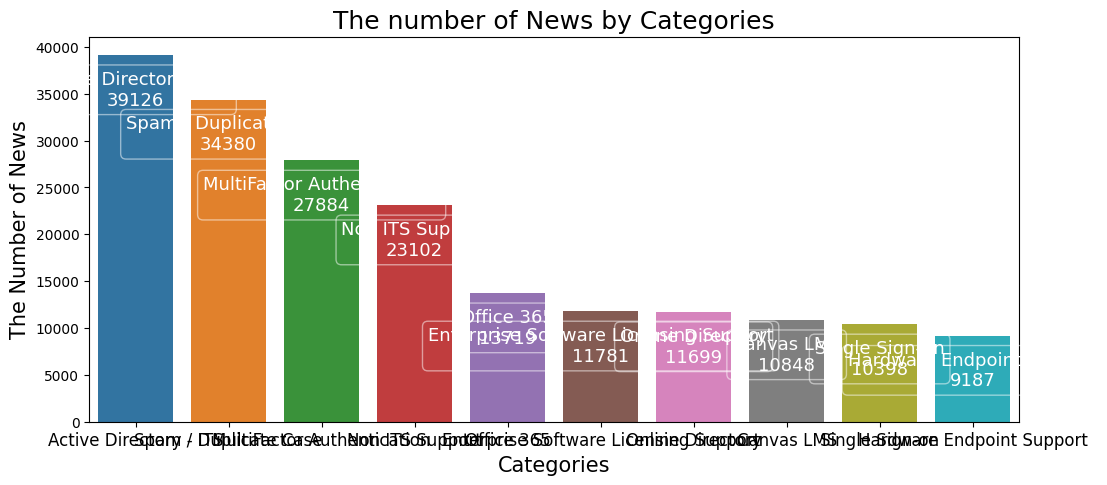

In [6]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)

plt.show()

In [7]:
df_top10 = df[(df['u_organization'] == "IT Services") & (df['service_offering'].apply(lambda s: s in categories))]
df_top10

,Unnamed: 0,short_description,description,service_offering,business_service,resolved_at,u_case_type,u_organization
0,0,LogPoint Call - UCSD,received from: mike@lh.logpointus.com\n\nHi Ro...,Office 365,Collaboration Services,2023-02-06 23:22:49,Request,IT Services
3,3,Triton link & E-mail Account,My student email account was converted from st...,Non ITS Support,Service Notifications & External Support,2023-01-19 07:40:12,Request,IT Services
4,4,Alondra Orozco Osuna - VC Student Affairs - Ch...,Fix email and active directory set-up.\n\nThis...,Active Directory - ITS,Access & Identity Management,2022-12-23 15:33:10,Request,IT Services
5,5,Academic Software License Request for: Leslie ...,See variables tab for additional information.,Enterprise Software Licensing Support,End-Point Support,2022-01-19 08:42:54,Request,IT Services
8,9,Fwd: [Scripps IT] Update: Account Creation Req...,"received from: thornton.alex@gmail.com\n\nHi,\...",Active Directory - ITS,Access & Identity Management,2023-02-10 12:43:29,Request,IT Services
...,...,...,...,...,...,...,...,...
914009,999945,Checking status of Duo Account,Checking status of Duo Account,MultiFactor Authentication,Access & Identity Management,2020-10-08 17:47:35,Request,IT Services
914017,999953,User lockout report,received from: no-reply@duosecurity.com\n\nUse...,MultiFactor Authentication,Access & Identity Management,2020-10-09 07:55:16,Incident,IT Services
914027,999974,Please give access to INTL 190 G00 & H00 (they...,"received from: aboudsady@UCSD.EDU\n\nHi Team,\...",Canvas LMS,Learning Management Systems & Integrations,2020-10-09 07:30:24,Request,IT Services
914031,999978,Tamara Renteria - New Laptop Setup - OIC,Tamara Renteria - New Laptop Setup - OIC,Hardware Endpoint Support,End-Point Support,2020-10-08 15:54:55,Request,IT Services


In [8]:

# Sampling with same size for each catagory
size =  1000

# create an empty dataframe to store the sampled rows
df_for_training = pd.DataFrame()

# loop through each group and sample the same number of rows for each group
for i, group in enumerate(categories):
    group_df = df_top10[df_top10['service_offering'] == group].sample(size,random_state=123)
    group_df['encoded_text'] = np.repeat(i, size)
    df_for_training = pd.concat([df_for_training, group_df])

# print the sampled dataframe
df_for_training

,Unnamed: 0,short_description,description,service_offering,business_service,resolved_at,u_case_type,u_organization,encoded_text
507427,560599,Account Request: Please create network credent...,received from: rndiaye@ucsd.edu\n\nHello Accou...,Active Directory - ITS,Access & Identity Management,2021-12-09 08:47:38,Request,IT Services,0
175120,188583,Need Student Employee Account <Imhee Moe>,"received from: pschwartz@ucsd.edu\n\nHi all,\n...",Active Directory - ITS,Access & Identity Management,2022-08-30 10:27:09,Request,IT Services,0
882300,966709,Please move user object socherif to the People OU,received from: do-not-reply@ucsd.edu\n\nPostMa...,Active Directory - ITS,Access & Identity Management,2020-11-04 14:04:01,Request,IT Services,0
479358,530939,Question about password reset,User wondered if she would have to sign out of...,Active Directory - ITS,Access & Identity Management,2022-01-10 17:05:45,Request,IT Services,0
302503,329831,"EH&S TPCS, Ste. 450: Remove Gina Sunda from EH...","Hello, ITS,\n\nPlease remove Gina Sunda from E...",Active Directory - ITS,Access & Identity Management,2022-05-02 08:52:54,Request,IT Services,0
...,...,...,...,...,...,...,...,...,...
129903,139973,ITS-MAY2110-04,"received from: bhanson@physics.ucsd.edu\n\nHi,...",Hardware Endpoint Support,End-Point Support,2022-09-29 09:24:33,Incident,IT Services,9
210292,228151,new ethernet connection for computer (2),Need wall jack port activation and IP address ...,Hardware Endpoint Support,End-Point Support,2022-07-25 16:28:20,Request,IT Services,9
810437,889468,Remote Work Loaner,received from: speralta@ucsd.edu\n\nHi Service...,Hardware Endpoint Support,End-Point Support,2021-01-28 09:20:32,Incident,IT Services,9
108728,118128,Computer Malfunctioning in Gilman Parking Office,"received from: across@ucsd.edu\n\nHello,\n\nI ...",Hardware Endpoint Support,End-Point Support,2022-10-12 14:38:50,Incident,IT Services,9


In [9]:
# Proportional Sampling
#df_for_training = df_top10.sample(10000, random_state=123)

In [10]:
df_for_training['count'] = df_for_training['description'].apply(lambda x: len(x.split()))

<Figure size 800x800 with 0 Axes>

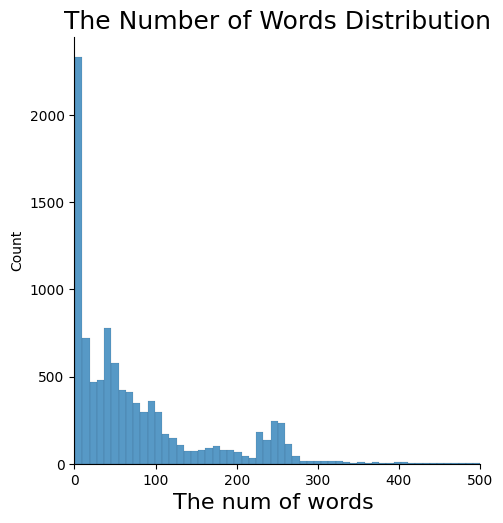

In [11]:
plt.figure(figsize= (8, 8))

sns.displot(df_for_training['count'])

plt.xlim(0, 500)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [12]:
df_for_training['encoded_text'] = df_for_training['service_offering'].astype('category').cat.codes

In [13]:
df_for_training

,Unnamed: 0,short_description,description,service_offering,business_service,resolved_at,u_case_type,u_organization,encoded_text,count
507427,560599,Account Request: Please create network credent...,received from: rndiaye@ucsd.edu\n\nHello Accou...,Active Directory - ITS,Access & Identity Management,2021-12-09 08:47:38,Request,IT Services,0,125
175120,188583,Need Student Employee Account <Imhee Moe>,"received from: pschwartz@ucsd.edu\n\nHi all,\n...",Active Directory - ITS,Access & Identity Management,2022-08-30 10:27:09,Request,IT Services,0,49
882300,966709,Please move user object socherif to the People OU,received from: do-not-reply@ucsd.edu\n\nPostMa...,Active Directory - ITS,Access & Identity Management,2020-11-04 14:04:01,Request,IT Services,0,31
479358,530939,Question about password reset,User wondered if she would have to sign out of...,Active Directory - ITS,Access & Identity Management,2022-01-10 17:05:45,Request,IT Services,0,25
302503,329831,"EH&S TPCS, Ste. 450: Remove Gina Sunda from EH...","Hello, ITS,\n\nPlease remove Gina Sunda from E...",Active Directory - ITS,Access & Identity Management,2022-05-02 08:52:54,Request,IT Services,0,11
...,...,...,...,...,...,...,...,...,...,...
129903,139973,ITS-MAY2110-04,"received from: bhanson@physics.ucsd.edu\n\nHi,...",Hardware Endpoint Support,End-Point Support,2022-09-29 09:24:33,Incident,IT Services,3,37
210292,228151,new ethernet connection for computer (2),Need wall jack port activation and IP address ...,Hardware Endpoint Support,End-Point Support,2022-07-25 16:28:20,Request,IT Services,3,38
810437,889468,Remote Work Loaner,received from: speralta@ucsd.edu\n\nHi Service...,Hardware Endpoint Support,End-Point Support,2021-01-28 09:20:32,Incident,IT Services,3,50
108728,118128,Computer Malfunctioning in Gilman Parking Office,"received from: across@ucsd.edu\n\nHello,\n\nI ...",Hardware Endpoint Support,End-Point Support,2022-10-12 14:38:50,Incident,IT Services,3,117


In [14]:
data_texts = df_for_training['description'].to_list()

data_labels = df_for_training['encoded_text'].to_list()

In [15]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )

train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.1, random_state = 0 )

In [16]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', num_labels=category_num)

train_encodings = tokenizer(train_texts, truncation = True, padding = True  ) # padding to the longest sequence

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-26 23:51:18.863252: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-26 23:51:18.863275: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
train_dataset.element_spec

({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [19]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=category_num)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [20]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments


training_args = TFTrainingArguments(
    output_dir='./model/results',          
    num_train_epochs=7,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=1e-4,               
    logging_dir='./model/logs',            
    eval_steps=100                   
)

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = category_num)


trainer = TFTrainer(
    model=trainer_model,                 
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

In [21]:
trainer.train()

2023-03-26 23:51:27.674032: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 7200
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 512
        }
      }
      shape {
        dim {
          size: 512
        }
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-26 23:51:31.971098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [ ]:
trainer.evaluate()

In [22]:
save_directory = "./model/saved_models" 

trainer_model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)

('./model/saved_models/tokenizer_config.json',
 './model/saved_models/special_tokens_map.json',
 './model/saved_models/vocab.txt',
 './model/saved_models/added_tokens.json')

In [ ]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

In [ ]:
test_result = np.array([],dtype=int)
for i in range(len(test_labels)):
    test_text = test_texts[i]

    predict_input = tokenizer_fine_tuned.encode(
        test_text,
        truncation = True,
        padding = True,
        return_tensors = 'tf'    
    )

    output = model_fine_tuned(predict_input)[0]

    prediction_value = tf.argmax(output, axis = 1).numpy()[0]

    test_result = np.append(test_result, prediction_value)


In [ ]:
test_labels = np.array(test_labels)

In [ ]:
test_result

In [ ]:
test_labels

In [ ]:
np.mean(test_result == test_labels)